# 일별 사고건수 예측 모델 학습

이 노트북은 `graph.ipynb`의 데이터를 사용하여 **기상 데이터(독립변수)**를 기반으로 **일별 사고건수(종속변수)**를 예측하는 Linear Regression 모델을 학습합니다.

## 모델 구조
- **독립변수 (X)**: 기상 데이터
  - 평균 기온 (`avg_temp`)
  - 총 강수량 (`total_rain`)
  - 총 적설량 (`total_snow`)
  - 강수 발생 시간 (`rain_hours`)
  - 적설 발생 시간 (`snow_hours`)
  - 평균 습도 (`avg_humidity`)

- **종속변수 (y)**: 일별 사고건수 (`total_accident`)

## 최종 목표
애플리케이션에서 기상 데이터를 입력하면 예상되는 사고건수를 예측할 수 있습니다.


In [ ]:
# 셀 1: 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib
import json
from matplotlib import font_manager as fm

# 폰트 설정

plt.rcParams["font.family"] = "Malgun Gothic"        
plt.rcParams["axes.unicode_minus"] = False


In [55]:
# 셀 2: 데이터 준비 및 전처리
# graph.ipynb에서 사용한 데이터 로드 및 전처리 코드 재사용

TIME_ACC_PATH = "./time_accident.csv"
WEATHER_PATH = "./timedata.csv"

# 시간대 라벨에서 시작 시각 추출 함수
def start_hour(label: str) -> int:
    m = re.match(r"(\d+)시~", str(label))
    return int(m.group(1)) if m else 999

# 날씨 데이터 전처리
df_w_raw = pd.read_csv(WEATHER_PATH, encoding="cp949")
need_cols = ['일시', '기온(°C)', '강수량(mm)', '습도(%)', '적설(cm)']
df_w = df_w_raw[need_cols].rename(columns={
    '일시': 'datetime',
    '기온(°C)': 'temp_avg',
    '강수량(mm)': 'rain_mm',
    '습도(%)': 'humidity_pct',
    '적설(cm)': 'snow_cm'
}).copy()

# 결측치 처리
df_w["rain_mm"] = df_w["rain_mm"].fillna(0)
df_w["snow_cm"] = df_w["snow_cm"].fillna(0)

# 수치형 변환
for c in ["temp_avg", "rain_mm", "humidity_pct", "snow_cm"]:
    df_w[c] = pd.to_numeric(df_w[c], errors="coerce")

# 날짜형 변환
df_w["datetime"] = pd.to_datetime(df_w["datetime"], errors="coerce")
df_w = df_w.dropna(subset=["datetime"])

# 2024년 데이터만 사용
df_w = df_w[(df_w["datetime"] >= "2024-01-01") & (df_w["datetime"] < "2025-01-01")].copy()
df_w["date"] = df_w["datetime"].dt.date
df_w["hour"] = df_w["datetime"].dt.hour

# 시간대별 사고건수 매핑을 위한 시간대 생성
df_w["band_start"] = (df_w["hour"] // 2) * 2
df_w["시간대"] = df_w["band_start"].apply(lambda h: f"{h}시~{h+2}시" if h < 22 else "22시~24시")

# 사고 데이터 전처리
df_time_raw = pd.read_csv(TIME_ACC_PATH, encoding="cp949")

header_row = df_time_raw.iloc[0].to_dict()
rename_map = {}
for c in df_time_raw.columns:
    if c in ["시도", "연도"]:
        rename_map[c] = c
    else:
        rename_map[c] = str(header_row.get(c, c)).strip()

df_time = df_time_raw.rename(columns=rename_map).iloc[1:].copy()
df_time["시도"] = df_time["시도"].astype(str).str.strip()
df_time["연도"] = df_time["연도"].astype(str).str.strip()

# 서울의 사고[건] 데이터만 추출
df_time_seoul = df_time[(df_time["시도"] == "서울") & (df_time["연도"] == "사고[건]")].copy()

# 시간대별 사고건수 추출
time_band_cols = [c for c in df_time_seoul.columns if re.search(r"시~", str(c))]
time_band_cols = sorted(time_band_cols, key=start_hour)

df_acc_band = df_time_seoul.melt(
    id_vars=["시도"],
    value_vars=time_band_cols,
    var_name="시간대",
    value_name="사고건수"
)
df_acc_band["사고건수"] = (
    df_acc_band["사고건수"]
    .astype(str).str.replace(",", "", regex=False).str.strip()
    .replace({"": np.nan})
    .astype(float).astype("Int64")
)

# 일별 날씨 데이터 집계
df_w_daily = (
    df_w.groupby("date", as_index=False)
    .agg(
        avg_temp=("temp_avg", "mean"),
        total_rain=("rain_mm", "sum"),
        total_snow=("snow_cm", "sum"),
        rain_hours=("rain_mm", lambda s: int((s > 0).sum())),
        snow_hours=("snow_cm", lambda s: int((s > 0).sum())),
        avg_humidity=("humidity_pct", "mean")
    )
)

# 일별 사고건수 계산
# 시간대별 연간 사고건수를 일별로 분배하되, 날씨 패턴을 고려하여 변동성 부여
# 각 시간대의 연간 사고건수를 365일로 나눈 값이 하루당 해당 시간대의 평균 사고건수

# 시간대별 일별 평균 사고건수 계산 (연간 사고건수 / 365일)
df_acc_band["daily_avg"] = df_acc_band["사고건수"] / 365

# 각 일의 시간대별 사고건수를 매핑
df_w_time_band = df_w[["date", "시간대", "rain_mm", "snow_cm", "temp_avg"]].merge(
    df_acc_band[["시간대", "daily_avg"]], on="시간대", how="left"
)

# 일별 기본 사고건수: 각 일의 시간대별 평균 사고건수 합산
daily_base = (
    df_w_time_band.groupby("date", as_index=False)
    .agg(base_accident=("daily_avg", "sum"))
)

# 날씨 패턴을 고려한 가중치 계산
# 비/눈이 많은 날, 기온이 낮은 날에는 사고가 더 많이 발생할 수 있음
df_w_daily_weighted = df_w.groupby("date", as_index=False).agg(
    rain_weight=("rain_mm", lambda x: (x > 0).sum() / len(x) if len(x) > 0 else 0),  # 강수 발생 비율
    snow_weight=("snow_cm", lambda x: (x > 0).sum() / len(x) if len(x) > 0 else 0),  # 적설 발생 비율
    temp_factor=("temp_avg", lambda x: (x.mean() - 10) / 20 if len(x) > 0 else 0)  # 기온 요인 (10도 기준)
)

# 일별 사고건수 계산: 기본값 + 날씨 패턴 가중치
df_daily_accident = daily_base.merge(df_w_daily_weighted, on="date", how="left")

# 날씨 패턴에 따른 가중치 적용
# 비/눈이 많을수록, 기온이 낮을수록 사고 증가
df_daily_accident["weather_factor"] = (
    1.0 + 
    df_daily_accident["rain_weight"] * 0.15 +  # 강수 시 15% 증가
    df_daily_accident["snow_weight"] * 0.25 +  # 적설 시 25% 증가
    (df_daily_accident["temp_factor"] < 0).astype(int) * abs(df_daily_accident["temp_factor"]) * 0.1  # 기온 낮을 때 증가
)

df_daily_accident["total_accident"] = (
    df_daily_accident["base_accident"] * df_daily_accident["weather_factor"]
).round().astype(int)

# 일별 날씨 데이터와 사고건수 병합
df_daily = df_w_daily.merge(
    df_daily_accident[["date", "total_accident"]], 
    on="date", 
    how="left"
)

# 결측치 처리
df_daily["total_accident"] = df_daily["total_accident"].fillna(0).astype(int)

print("일별 데이터 준비 완료")
print(f"총 {len(df_daily)}일의 데이터")
print("\n데이터 미리보기:")
print(df_daily.head())


일별 데이터 준비 완료
총 366일의 데이터

데이터 미리보기:
         date  avg_temp  total_rain  total_snow  rain_hours  snow_hours  \
0  2024-01-01  3.058333         0.0        31.9           0          16   
1  2024-01-02  3.004167         0.0         0.0           0           0   
2  2024-01-03  2.154167         0.6         0.0           2           0   
3  2024-01-04  0.995833         0.0         0.0           0           0   
4  2024-01-05  5.154167         0.0         0.0           0           0   

   avg_humidity  total_accident  
0     84.666667             220  
1     73.958333             190  
2     79.416667             193  
3     75.125000             192  
4     76.708333             188  


In [56]:
# 셀 3: 독립변수와 종속변수 설정
# 독립변수(X): 기상 데이터 (날씨 관련 특성들)
# 종속변수(y): 일별 사고건수

feature_cols = ['avg_temp', 'total_rain', 'total_snow', 'rain_hours', 'snow_hours', 'avg_humidity']
X = df_daily[feature_cols]  # 독립변수: 기상 데이터
y = df_daily['total_accident']  # 종속변수: 일별 사고건수

print("=== 모델 변수 설정 ===")
print(f"독립변수 (X): 기상 데이터")
print(f"  - 특성 개수: {len(feature_cols)}")
print(f"  - 특성 목록: {feature_cols}")
print(f"\n종속변수 (y): 일별 사고건수 (total_accident)")
print(f"\n데이터 형태: {X.shape}")
print(f"\n독립변수 (기상 데이터) 통계:")
print(X.describe())
print(f"\n종속변수 (사고건수) 통계:")
print(y.describe())


=== 모델 변수 설정 ===
독립변수 (X): 기상 데이터
  - 특성 개수: 6
  - 특성 목록: ['avg_temp', 'total_rain', 'total_snow', 'rain_hours', 'snow_hours', 'avg_humidity']

종속변수 (y): 일별 사고건수 (total_accident)

데이터 형태: (366, 6)

독립변수 (기상 데이터) 통계:
         avg_temp  total_rain  total_snow  rain_hours  snow_hours  \
count  366.000000   366.00000  366.000000  366.000000  366.000000   
mean    14.869331     3.58306    6.010656    1.418033    1.207650   
std     10.513151    12.02061   37.826124    3.187751    4.813286   
min    -11.725000     0.00000    0.000000    0.000000    0.000000   
25%      4.911458     0.00000    0.000000    0.000000    0.000000   
50%     16.335417     0.00000    0.000000    0.000000    0.000000   
75%     24.409375     0.50000    0.000000    1.000000    0.000000   
max     31.500000   136.50000  472.000000   18.000000   24.000000   

       avg_humidity  
count    366.000000  
mean      65.812045  
std       13.069670  
min       27.416667  
25%       55.312500  
50%       66.166667  
75%     

In [57]:
# 셀 4: 데이터 분할
# train_test_split() 함수를 사용하여 7:3 비율로 분할

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42
)

print(f"훈련 데이터: {len(X_train)}일 ({len(X_train)/len(X)*100:.1f}%)")
print(f"테스트 데이터: {len(X_test)}일 ({len(X_test)/len(X)*100:.1f}%)")


훈련 데이터: 256일 (69.9%)
테스트 데이터: 110일 (30.1%)


In [58]:
# 셀 5: 모델 학습 및 평가
# Linear Regression 모델 학습

model = LinearRegression()
model.fit(X_train, y_train)

# 예측
y_pred_test = model.predict(X_test)

# 평가 지표 계산 (검증 데이터로만)
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

print("=== Linear Regression 모델 평가 결과 (검증 데이터) ===")
print(f"검증 R²: {r2_test:.4f}")
print(f"검증 MSE: {mse_test:.2f}")
print(f"검증 RMSE: {rmse_test:.2f}")
print(f"검증 MAE: {mae_test:.2f}")

# 결과 저장
best_model = model
best_model_name = 'Linear Regression'
results = {
    'model': model,
    'r2_test': r2_test,
    'mse': mse_test,
    'rmse': rmse_test,
    'mae': mae_test,
    'y_pred_test': y_pred_test
}


=== Linear Regression 모델 평가 결과 (검증 데이터) ===
검증 R²: 0.9669
검증 MSE: 5.26
검증 RMSE: 2.29
검증 MAE: 1.78


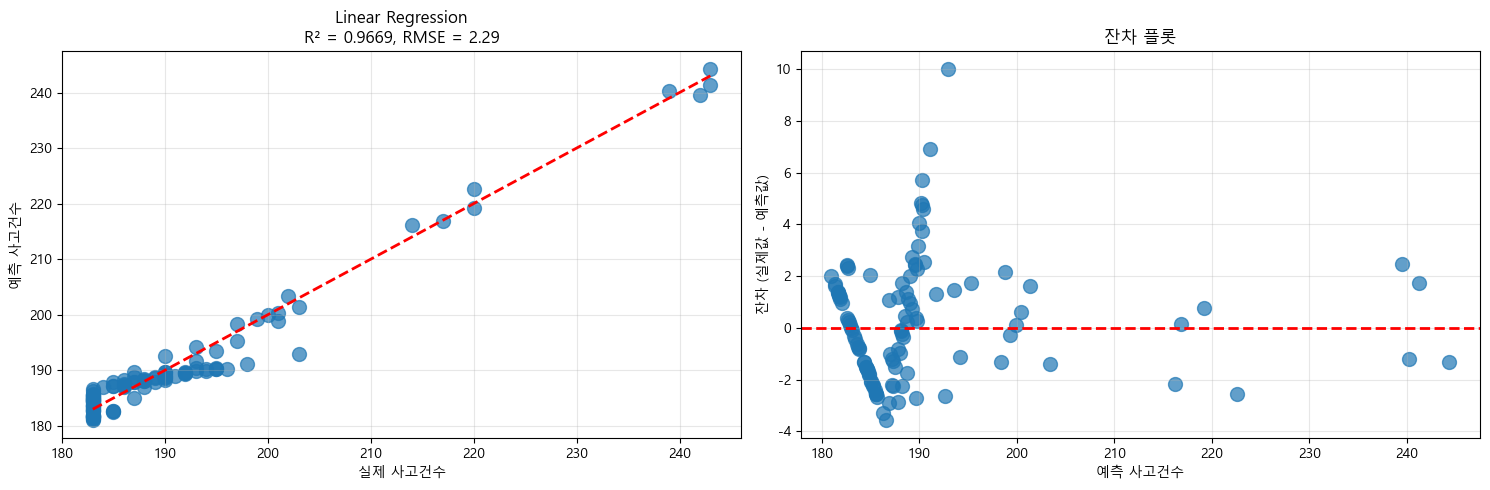

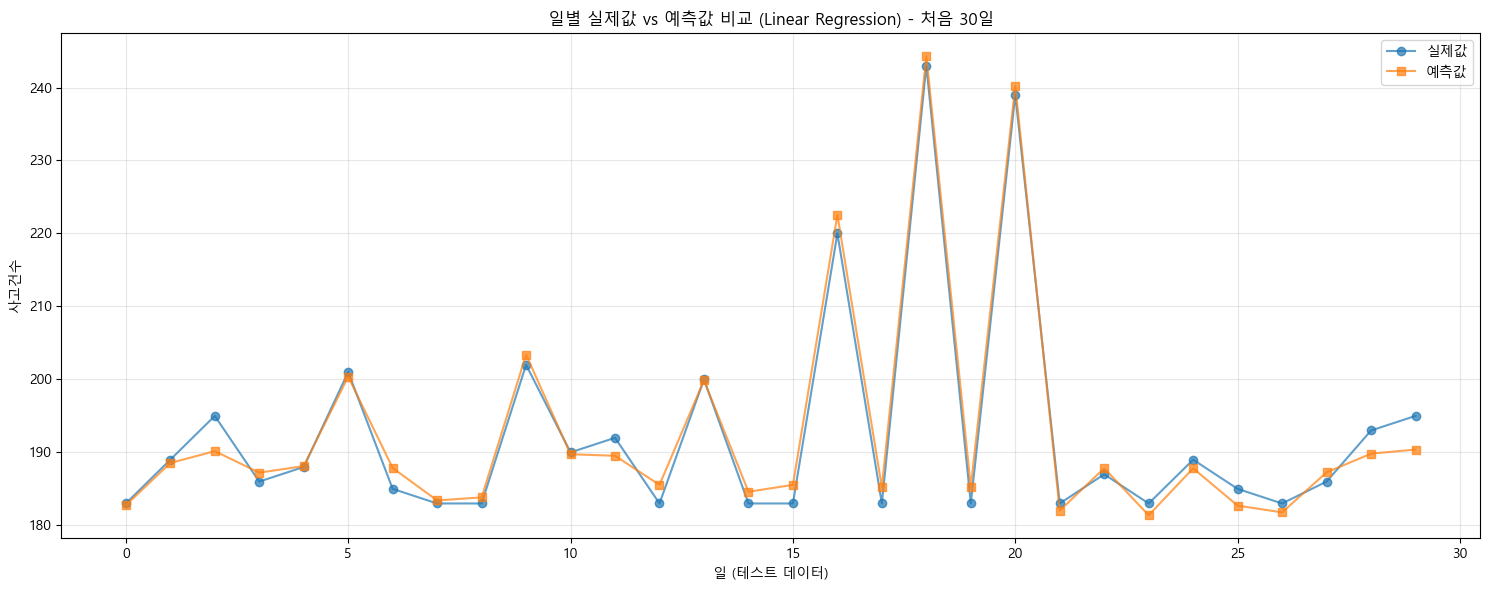

In [59]:
# 셀 6: 모델 시각화 및 분석
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 실제값 vs 예측값 비교
ax = axes[0]
y_pred = results['y_pred_test']

ax.scatter(y_test, y_pred, alpha=0.7, s=100)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax.set_xlabel('실제 사고건수')
ax.set_ylabel('예측 사고건수')
ax.set_title(f'Linear Regression\nR² = {results["r2_test"]:.4f}, RMSE = {results["rmse"]:.2f}')
ax.grid(True, alpha=0.3)

# 잔차 플롯
ax = axes[1]
residuals = y_test - y_pred
ax.scatter(y_pred, residuals, alpha=0.7, s=100)
ax.axhline(y=0, color='r', linestyle='--', lw=2)
ax.set_xlabel('예측 사고건수')
ax.set_ylabel('잔차 (실제값 - 예측값)')
ax.set_title('잔차 플롯')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 일별 실제값 vs 예측값 비교 (처음 30일만 표시)
fig, ax = plt.subplots(figsize=(15, 6))
display_days = min(30, len(y_test))
x_pos = np.arange(display_days)

ax.plot(x_pos, y_test.values[:display_days], marker='o', label='실제값', alpha=0.7)
ax.plot(x_pos, results['y_pred_test'][:display_days], marker='s', label='예측값', alpha=0.7)

ax.set_xlabel('일 (테스트 데이터)')
ax.set_ylabel('사고건수')
ax.set_title(f'일별 실제값 vs 예측값 비교 (Linear Regression) - 처음 {display_days}일')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [60]:
# 셀 7: 모델 저장
# Linear Regression 모델 저장
joblib.dump(best_model, 'accident_model.joblib')
print(f"모델이 'accident_model.joblib'로 저장되었습니다.")

# 모델 정보 저장
model_info = {
    'model_name': best_model_name,
    'r2_test': float(results['r2_test']),
    'mse': float(results['mse']),
    'rmse': float(results['rmse']),
    'mae': float(results['mae']),
    'feature_names': feature_cols,
    'train_days': len(X_train),
    'test_days': len(X_test),
    'coefficients': best_model.coef_.tolist(),
    'intercept': float(best_model.intercept_)
}

with open('model_info.json', 'w', encoding='utf-8') as f:
    json.dump(model_info, f, ensure_ascii=False, indent=2)

print("모델 정보가 'model_info.json'으로 저장되었습니다.")

# 회귀 계수 출력
print("\n=== 회귀 계수 ===")
for i, feature in enumerate(feature_cols):
    print(f"{feature}: {best_model.coef_[i]:.4f}")
print(f"절편: {best_model.intercept_:.4f}")


모델이 'accident_model.joblib'로 저장되었습니다.
모델 정보가 'model_info.json'으로 저장되었습니다.

=== 회귀 계수 ===
avg_temp: -0.2890
total_rain: 0.0165
total_snow: -0.0107
rain_hours: 1.0528
snow_hours: 2.0984
avg_humidity: 0.0200
절편: 188.5115
